In [6]:
import os 
import tweepy as tw
import pandas as pd
import json
import datetime
import re
import json
import numpy as np
import pickle
import joblib

from textblob import TextBlob 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from pull_tweets import import_from_json, json_extract_text

Here, we use the Twitter API to get the tweets for the top Democratic Presidential Candidates since 05/01/19. These include:  

* Joe Biden - @JoeBiden
* Elizabeth Warren - @SenWarren
* Bernie Sanders - @BernieSanders
* Pete Buttigieg - @PeteButtigieg
* Kamala Harris - @KamalaHarris

Maybe?  
* Andrew Yang - @AndrewYang
* Amy Klobuchar - @amyklobuchar

# Part 1 - Twitter Data

In [7]:
def get_tweets(handle='JoeBiden') :
    
    consumer_key = '7KEQmTV6fhm0mnmsyO9XNKPpx'
    consumer_secret = 'bevlcE2PiQAu0bMgSsBj1QrpOVdC3KGVyNvwu8A1rnlozLIUlq'
    access_token = '139221007-Oxzs1aPNr0pQefpVd5jeDfogKC9CktkiGityJGSJ'
    access_token_secret = '6EN5WAOCWH7E6avW9uomIvRYwQZfFxnBJS1yKCj3qJYRx'

    counter = 0
    final_dict = {}
    
    auth = tw.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tw.API(auth, wait_on_rate_limit=True)

    path = '../data/' + handle + '.json'

    # Check to see if we've pulled yet
    if not os.path.isfile(path):    
        for status in tw.Cursor(api.user_timeline, screen_name='@' + handle, tweet_mode="extended").items():
            print(status.created_at)
            curr_dict = {}
            curr_dict['text'] = status.full_text
            curr_dict['date'] = str(status.created_at)
            final_dict[counter] = curr_dict
            counter += 1
            end_date = datetime.datetime.strptime("07/01/19", "%m/%d/%y")
            if status.created_at < end_date :
                break


            with open(path, 'w', encoding='utf-8') as json_file:
                json.dump(final_dict, json_file)


## Pull Data
Loop through candidate handles and create json files of the tweets for each candidates.

In [8]:
%%time
candidate_handles = ['JoeBiden', 'SenWarren', 'BernieSanders', 'PeteButtigieg', 'KamalaHarris']
# candidate_handles = ['AndrewYang', 'amyklobuchar']
for h in candidate_handles:
    get_tweets(handle=h)

CPU times: user 695 µs, sys: 213 µs, total: 908 µs
Wall time: 785 µs


# Part 2 - Modeling (Clustering)

In [9]:
text=[]
data = import_from_json("../data/BernieSanders.json")
text += json_extract_text(data)
data = import_from_json("../data/PeteButtigieg.json")
text += json_extract_text(data)
data = import_from_json("../data/KamalaHarris.json")
text += json_extract_text(data)
data = import_from_json("../data/JoeBiden.json")
text += json_extract_text(data)
data = import_from_json("../data/SenWarren.json")
text += json_extract_text(data)


In [10]:
%%time

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(text)

true_k = 8
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

# try_to_guess = text[:4]
# for i in try_to_guess :
#     Y = vectorizer.transform([i])
#     prediction = model.predict(Y)
#     print(i)
#     print(prediction)

CPU times: user 10.5 s, sys: 150 ms, total: 10.7 s
Wall time: 2.94 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=8, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

## Pickle Model and Vectorizer

In [11]:
# # Pickle Model
path = 'models/final_prediction.pickle'
pickle.dump(model, open(path, 'wb'))

In [12]:
path = 'models/final_vectorizer.pickle'
pickle.dump(vectorizer, open(path, 'wb'))

In [16]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 https
 president
 people
 america
 time
 country
 gun
 need
 end
 today
Cluster 1:
 rt
 berniesanders
 peteforamerica
 petebuttigieg
 https
 bernie
 new
 plan
 kamalaharris
 sanders
Cluster 2:
 fight
 https
 stand
 justice
 rights
 people
 proud
 president
 rt
 women
Cluster 3:
 care
 health
 medicare
 right
 https
 insurance
 affordable
 need
 access
 americans
Cluster 4:
 campaign
 https
 join
 people
 country
 going
 iowa
 movement
 live
 new
Cluster 5:
 trump
 donald
 president
 https
 going
 defeat
 tax
 people
 country
 american
Cluster 6:
 workers
 pay
 wage
 teachers
 https
 fair
 stand
 wages
 deserve
 union
Cluster 7:
 amp
 climate
 change
 crisis
 https
 new
 deal
 green
 fossil
 fuel


### Prediction

In [17]:
try_to_guess = text[:5]
for i in try_to_guess :
    Y = vectorizer.transform([i])
    prediction = model.predict(Y)
    print(i)
    print(prediction)

RT @daylonprochaska: The movement around bernie is, ideologically, something we haven’t seen in decades. With the climate crisis looming, w…
[1]
RT @pujanpatel_: Bernie is one of the only presidential candidates that cares about my voice, and the collective voice of the working class…
[1]
RT @israhirsi: Officially the youngest endorser for the campaign! #Bernie2020 https://t.co/AE8HrXkgTH
[1]
Young people across the country are leading a movement to end the school-to-prison and deportation pipelines. When we are in the White House, together we'll create supportive school communities for all students and end all forms of racial injustice and discrimination. https://t.co/C4TubAwosi
[0]
The time is long overdue for the U.S. government to stand with family farmers. If I am elected president, we will break up massive agriculture corporations and revitalize rural America. Join us live from Iowa Falls: https://t.co/qWSETL80mb
[0]


In [18]:
N = 10
print(text[N])
model.predict(vectorizer.transform([text[N]]))[0]

Some campaigns give updates to their donors at closed-door fundraisers over hors d'oeuvres.

Our campaign is a little different.

Live tonight at 11 pm EST, campaign manager @fshakir will give another update for our grassroots supporters. And this time he'll have a special guest.


4

## Create prediction.py

In [65]:
try_to_guess = text[:5]
for i in try_to_guess :
    Y = vectorizer.transform([i])
    prediction = loaded_model.predict(Y)
    print(i)
    print(prediction)

Iowa Chief Justice Mark Cady leaves behind a powerful legacy of protecting the rights of young Iowans and LGBTQ Americans. He will be greatly missed. https://t.co/32hMh6AVGR
[0]
RT @ninaturner: Oooooooowee, what @shannondjackson said! We were feelin the Bern tonight! Thank you Bedford and Cambridge for spending your…
[5]
The #GreenNewDeal is possible and necessary. Pass it on. https://t.co/P7kKPEDq35
[0]
RT @fresnocity: Thousands came to the @fresnocity campus for the @BernieSanders rally. https://t.co/oIxh2VHZbv
[5]
Thank you Fresno! It is great to be back in California. Together, we are going to defeat Trump and pass a Green New Deal to address the climate crisis and create 20 million jobs. https://t.co/ARinUuFJif
[6]


In [19]:
# load the model from disk
model_path = 'models/final_prediction.pickle'
vectorizer_path = 'models/final_vectorizer.pickle'
loaded_model = pickle.load(open(model_path, 'rb'))
vectorizer = pickle.load(open(vectorizer_path, 'rb'))

In [24]:
def make_prediction(input_tweets, model=loaded_model):
    predictions_list = []
    for t in input_tweets:
        tweet = vectorizer.transform([t])
        pred_cluster = model.predict(tweet)[0]
        predictions_list.append(pred_cluster)
        print("Predicted_Cluster: {}".format(pred_cluster))
    return (predictions_list) # can maybe map to dictionary

In [26]:
l = make_prediction(text[:20])
print(l)

Predicted_Cluster: 0
Predicted_Cluster: 5
Predicted_Cluster: 0
Predicted_Cluster: 5
Predicted_Cluster: 6
Predicted_Cluster: 0
Predicted_Cluster: 1
Predicted_Cluster: 1
Predicted_Cluster: 5
Predicted_Cluster: 2
Predicted_Cluster: 5
Predicted_Cluster: 0
Predicted_Cluster: 0
Predicted_Cluster: 1
Predicted_Cluster: 1
Predicted_Cluster: 5
Predicted_Cluster: 7
Predicted_Cluster: 0
Predicted_Cluster: 5
Predicted_Cluster: 0
[0, 5, 0, 5, 6, 0, 1, 1, 5, 2, 5, 0, 0, 1, 1, 5, 7, 0, 5, 0]


In [29]:
text[3]

'RT @fresnocity: Thousands came to the @fresnocity campus for the @BernieSanders rally. https://t.co/oIxh2VHZbv'

In [17]:
make_prediction(text[:3])


NameError: name 'make_prediction' is not defined

In [2]:
%%bash
which python

/Users/jonathan/anaconda/envs/cs410/bin/python


In [1]:
from flask import jsonify

ModuleNotFoundError: No module named 'flask'

# Experimentation - 
Goal was to Correlate Polling Results w/ Sentiment

## Extract Sentiment Scores
Create weekly sentiment score for our candidates from 05/01/19 - 11/01/19.

In [6]:
def clean_tweet(tweet): 
    ''' 
    Utility function to clean tweet text by removing links, special characters 
    using simple regex statements. 
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

In [7]:
def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(clean_tweet(tweet)) 
        # set sentiment 
        return analysis.sentiment.polarity
        # if analysis.sentiment.polarity > 0: 
        #     return 'positive'
        # elif analysis.sentiment.polarity == 0: 
        #     return 'neutral'
        # else: 
        #     return 'negative'


In [8]:
def sentiment_by_days(start_date, num_of_days, tweets) :
    tweet_count = 0 
    sentiment_sum = 0 
    start = start_date
    end = start_date  + datetime.timedelta(days=num_of_days)
    print(start)
    print(end)
    for key, value in tweets.items():
        curr_date = datetime.datetime.strptime(value['date'], "%Y-%m-%d %H:%M:%S")
        if curr_date >= start and curr_date < end : 
            tweet_count += 1 
            sentiment_sum += get_tweet_sentiment(value['text'])
    return sentiment_sum / tweet_count

In [0]:
%%time
candidate_handles = ['JoeBiden', 'SenWarren', 'BernieSanders', 'PeteButtigieg', 'KamalaHarris']
# candidate_handles = ['AndrewYang', 'amyklobuchar']]

for cand in candidate_handles:
    print(cand)
    cand_path = 'data/' + cand + '.json'
    with open(cand_path) as json_file:
        data = json.load(json_file)

    curr_date = datetime.datetime.strptime("05/01/19", "%m/%d/%y")
    complete_date = datetime.datetime.strptime("11/01/19", "%m/%d/%y")
    sent_dict = {}
    while(curr_date < complete_date) :
        curr_sent = sentiment_by_days(curr_date, 7, data) 
        end_date = curr_date  + datetime.timedelta(days=7)
        sent_dict[str(end_date)]  = curr_sent
        curr_date += datetime.timedelta(days=7)
    print(sent_dict)

    cand_sent_path = 'data/' + cand + '_sent.json'
    with open(cand_sent_path, 'w') as json_file:
            json.dump(sent_dict, json_file)

## Organize Sentiment Scores
Steps:  
* Convert the json sentiment scores into a pandas dataframe with a column for each candidate.
* Filter sentiment scores to the most recent 1 month?

In [225]:
candidate_handles = ['JoeBiden', 'SenWarren', 'BernieSanders', 'PeteButtigieg', 'KamalaHarris']
df_sent = pd.DataFrame()
for cand in candidate_handles:
    cand_sent_path = 'data/' + cand + '_sent.json'
    ser = pd.read_json(cand_sent_path, typ='series')
    df_sent[cand] = ser
#     with open(cand_sent_path, 'r') as json_file:
#         data = json.load(json_file)
#         df_sent[cand] = data


In [232]:
df_sent['end_date'] = df_sent.index
df_sent = df_sent[(df_sent['end_date'] < '2019-10-27') & (df_sent['end_date'] >= '2019-10-01')]
df_sent = df_sent.drop('end_date', 1)
df_sent

,JoeBiden,SenWarren,BernieSanders,PeteButtigieg,KamalaHarris
2019-10-02,0.068147,0.039470,0.139237,0.213173,0.112059
2019-10-09,0.102347,0.175370,0.196806,0.071675,0.100850
2019-10-16,0.088505,0.129198,0.113038,0.203512,0.174765
2019-10-23,0.097825,0.017157,0.134056,0.088568,0.097215


In [234]:
df_sent.T

,2019-10-02,2019-10-09,2019-10-16,2019-10-23
JoeBiden,0.068147,0.102347,0.088505,0.097825
SenWarren,0.039470,0.175370,0.129198,0.017157
BernieSanders,0.139237,0.196806,0.113038,0.134056
PeteButtigieg,0.213173,0.071675,0.203512,0.088568
KamalaHarris,0.112059,0.100850,0.174765,0.097215


## RealClearPolitics Data

Polling data is gathered copied from [Real Clear Politics](https://www.realclearpolitics.com/epolls/2020/president/us/2020_democratic_presidential_nomination-6730.html). We just copied and pasted this into Excel to produce a .csv and ensured that we were selecting only 2019 data for the purposes of this project.

Preprocessing Steps:
1. convert date range column into two columns for beginning and end date by splitting on '-'
2. Replace cells of NAs or '--' with 0
3. Filter criteria
    * Only care about polling data that occurs after a given date (twitter data and corresponding sentiment scores must occur prior to this date)
    * Only columns corresponding to: Biden, Warren, Sanders, Buttigleg, Harris
4. Take the average across a column (for unique polls) for each candidate
    * we need to exclude the RCP Average since we are computing our own for a given date range
    * we also only care about the lastest polling results for a given polling source
5. Finally, we only care about the top 5 candidates for the purpose of this exercise (Biden, Warren, Sanders, Buttigieg, Harris) so we'll filter to those. We also need to ensure that the polling values are numeric.

In [192]:
df_polling = pd.read_csv('data/polling.csv')
# split Date column into beginning and end of date range
df_polling[['Initial_Date', 'End_Date']] = df_polling['Date'].str.split("-", expand=True)
df_polling = df_polling.iloc[1:] # drop RCP Average row
df_polling.head()

,Poll,Date,Biden,Warren,Sanders,Buttigieg,Harris,Yang,Klobuchar,Booker,Castro,Gabbard,Steyer,Bullock,Delaney,Spread,Initial_Date,End_Date
1,Economist/YouGov,11/10 - 11/12,23,26.0,17.0,9,5.0,4,2,1.0,2.0,2,1,1,1,Warren +3,11/10,11/12
2,Politico/Morning Consult,11/4 - 11/10,32,19.0,20.0,8,5.0,3,2,3.0,1.0,1,1,1,1,Biden +12,11/4,11/10
3,Economist/YouGov,11/3 - 11/5,26,25.0,14.0,8,6.0,1,2,2.0,3.0,3,1,1,1,Biden +1,11/3,11/5
4,Monmouth,10/30 - 11/3,23,23.0,20.0,9,5.0,3,2,3.0,0.0,0,1,0,0,Tie,10/30,11/3
5,The Hill/HarrisX,11/1 - 11/2,26,15.0,14.0,6,6.0,1,3,2.0,2.0,1,1,1,1,Biden +11,11/1,11/2


In [193]:
# convert date columns to dates
df_polling['Initial_Date'] = df_polling['Initial_Date'].str.strip() + '/19'
df_polling['End_Date'] = df_polling['End_Date'].str.strip() + '/19'

df_polling['Initial_Date'] = df_polling['Initial_Date'].apply(lambda x: dt.datetime.strptime(x, '%m/%d/%y'))
df_polling['End_Date'] = df_polling['End_Date'].apply(lambda x: dt.datetime.strptime(x, '%m/%d/%y'))

In [194]:
df_polling.head()

,Poll,Date,Biden,Warren,Sanders,Buttigieg,Harris,Yang,Klobuchar,Booker,Castro,Gabbard,Steyer,Bullock,Delaney,Spread,Initial_Date,End_Date
1,Economist/YouGov,11/10 - 11/12,23,26.0,17.0,9,5.0,4,2,1.0,2.0,2,1,1,1,Warren +3,2019-11-10,2019-11-12
2,Politico/Morning Consult,11/4 - 11/10,32,19.0,20.0,8,5.0,3,2,3.0,1.0,1,1,1,1,Biden +12,2019-11-04,2019-11-10
3,Economist/YouGov,11/3 - 11/5,26,25.0,14.0,8,6.0,1,2,2.0,3.0,3,1,1,1,Biden +1,2019-11-03,2019-11-05
4,Monmouth,10/30 - 11/3,23,23.0,20.0,9,5.0,3,2,3.0,0.0,0,1,0,0,Tie,2019-10-30,2019-11-03
5,The Hill/HarrisX,11/1 - 11/2,26,15.0,14.0,6,6.0,1,3,2.0,2.0,1,1,1,1,Biden +11,2019-11-01,2019-11-02


In [196]:
# drop polls after 2019-10-27, filter columns, and keep latest poll results for duplicates
df_polling_filtered = df_polling[df_polling['Initial_Date'] >= '2019-10-27']
df_polling_filtered = df_polling_filtered[['Poll', 'Initial_Date', 'End_Date', 'Biden', 'Warren', 'Sanders', 'Buttigieg', 'Harris']]
df_polling_filtered = df_polling_filtered.groupby(['Poll']).first().reset_index(0, drop=False)

df_polling_filtered

,Poll,Initial_Date,End_Date,Biden,Warren,Sanders,Buttigieg,Harris
0,ABC News/Wash Post,2019-10-27,2019-10-30,28,23.0,17.0,9,2.0
1,Economist/YouGov,2019-11-10,2019-11-12,23,26.0,17.0,9,5.0
2,FOX News,2019-10-27,2019-10-30,31,21.0,19.0,7,3.0
3,Harvard-Harris,2019-10-29,2019-10-31,33,15.0,18.0,4,5.0
4,Monmouth,2019-10-30,2019-11-03,23,23.0,20.0,9,5.0
5,NBC News/Wall St. Jrnl,2019-10-27,2019-10-30,27,23.0,19.0,6,4.0
6,Politico/Morning Consult,2019-11-04,2019-11-10,32,19.0,20.0,8,5.0
7,The Hill/HarrisX,2019-11-01,2019-11-02,26,15.0,14.0,6,6.0


In [256]:
df_polling_filtered.dtypes

Poll                    object
Initial_Date    datetime64[ns]
End_Date        datetime64[ns]
Biden                    int64
Warren                 float64
Sanders                float64
Buttigieg               object
Harris                 float64
dtype: object

In [255]:
df_polling_filtered['Buttigieg'].dtype

dtype('O')

In [261]:
# ensure poll results are numeric
df_polling_filtered[['Biden', 'Warren', 'Sanders', 'Buttigieg', 'Harris']] = df_polling_filtered[['Biden', 'Warren', 'Sanders', 'Buttigieg', 'Harris']].apply(pd.to_numeric)

# take the mean value and round to 2 places
df_polling_filtered[['Biden', 'Warren', 'Sanders', 'Buttigieg', 'Harris']].mean().round(2)

Biden        27.88
Warren       20.62
Sanders      18.00
Buttigieg     7.25
Harris        4.38
dtype: float64

## Correlation Analysis
Notes:
Sentiment correlation may not be so straightforward.
Maybe we can create a ranking algorithm that uses sentiment from the twitter data and some other features within a given time interval such as:
* number of total tweets
* number of positive tweets
* average sentiment

In [262]:
df_poll_average = df_polling_filtered[['Biden', 'Warren', 'Sanders', 'Buttigieg', 'Harris']].mean(axis=0).round(2)


In [263]:
type(df_poll_average)
df_poll_average

Biden        27.88
Warren       20.62
Sanders      18.00
Buttigieg     7.25
Harris        4.38
dtype: float64

In [264]:
df = df_sent.T
df['polling_avg'] = df_poll_average.values

In [265]:
df

,2019-10-02 00:00:00,2019-10-09 00:00:00,2019-10-16 00:00:00,2019-10-23 00:00:00,polling_avg
JoeBiden,0.068147,0.102347,0.088505,0.097825,27.88
SenWarren,0.039470,0.175370,0.129198,0.017157,20.62
BernieSanders,0.139237,0.196806,0.113038,0.134056,18.00
PeteButtigieg,0.213173,0.071675,0.203512,0.088568,7.25
KamalaHarris,0.112059,0.100850,0.174765,0.097215,4.38


In [268]:
import seaborn as sns
import matplotlib.pyplot as plt

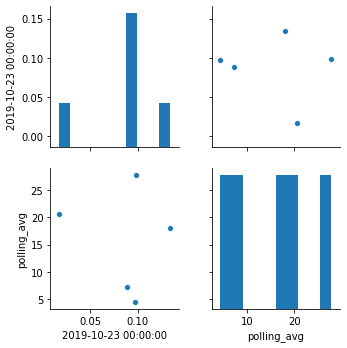

In [271]:
df_plot = df.iloc[:, 3:5]
df_plot
sns.pairplot(df_plot)